In [ ]:
#how data are represented at each level (forward, backward, forward with padding on top) needs a little
    #experimentation to determine the best representation
    #also, is encoding at each layer really the best way? or just feeding the raw through?
    
#Outside web ips are going to be a problem/messy/noisy. Start by categorizing all outside ips by <OUTSIDE_IP>
    #instead of the ip address, or another 4 digit symbol to insert into the hex string.
    
#to help the models generalize more, for a given source ip address with probability p (say p = 0.1) 
    #use the token <OTHER_MACHINE>
    
#should we remove random parts of the header, i.e. checksum

#should I take out bias for RNNs?

#for the decoder,does the fork encoding need to happen ?
    #do we simply cat the hContext with the next words?
    
#Should the architecture just be encode, context and then prediction???

#Input data, should it have character and hex pair encoding as well?

In [1]:
%matplotlib inline

import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu,optimizer=fast_compile'

import sys
import binascii
import multiprocessing as mp
from itertools import chain
from scapy.all import *
sys.path.append('hed-dlg/')

import numpy as np
import random
from scipy.stats import itemfreq
import matplotlib.pyplot as plt

import blocks
from blocks.bricks import Linear, Softmax, Softplus, NDimensionalSoftmax, BatchNormalizedMLP, \
                                Rectifier, Logistic, Tanh, MLP
from blocks.bricks.recurrent import GatedRecurrent, Fork, LSTM
from blocks.initialization import Constant, IsotropicGaussian, Identity, Uniform
from blocks.bricks.cost import BinaryCrossEntropy, CategoricalCrossEntropy
from blocks.filter import VariableFilter
from blocks.roles import PARAMETER
from blocks.graph import ComputationGraph

import theano
from theano import tensor as T

###These warnings do not impede progress
#WARNING: Failed to execute tcpdump. Check it is installed and in the PATH
#WARNING: No route found for IPv6 destination :: (no default route?)


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4007)


# Data

In [17]:
dataPath = '/data/fs4/datasets/pcaps/smallFlows.pcap'
pcaps = rdpcap(dataPath)
sessionPrep = pcaps.sessions()

In [3]:
def ipComs(listOsessions, hexOut = False):
    '''
    takes scapy sessions
    
    returns a dictionary of source ips and the ips they talk to, and a list of 
    all of the unique ip addresses in the data
    
    '''
    
    ipAddressDict = {}
    uniqIPs = []
    
    for k,v in listOsessions.items():
        for p in v:
            sourceIP = p.payload.fields['src']
            destIP = p.payload.fields['dst']
            
            #if source ip is not in dictionary, then add it with dest ip as list
            if sourceIP not in ipAddressDict:
                ipAddressDict[sourceIP] = [destIP]
            
            else:
                ipAddressDict[sourceIP] = list(set(ipAddressDict[sourceIP]) | set([destIP]))
            
            uniqIPs = list(set(uniqIPs) | set([destIP, sourceIP]))
            
    return ipAddressDict, uniqIPs
            

In [ ]:
sessionDict, uniqips = ipComs(sessionPrep)

In [4]:
def oneIpDirSwitcher(normHexSessionList):
    '''
    input is a list of packets from ONE session
    '''
    
    session = []
        
    for p in normHexSessionList:
        sourceIP = p[52:60]
        destIP = p[60:68]

        session.append(p[:52]+destIP+sourceIP+p[68:])

    return session

In [5]:
def ipDirectionSwitcher(hexSessionsDict):
    '''
    input is a dictionary of many sessions
    '''
    badSessions = {}
    
    for k in hexSessionsDict.keys():
        
        session = oneIpDirSwitcher(k)
        
        badSessions[k] = session
            
    return badSessions

In [20]:
#turns the sessions into a dictionary key = session_number, val = list of packages in hex

i=0
hexSessions = {}

for k,v in sessionPrep.items(): # v is the session
    #for attr, value in v.__dict__.iteritems(): THIS IS TO GET DICT OF VALUES
    #    print attr, value
    #if i == 2:
    #    break
    scpcaps = []    
    for p in v: #p is the individual packet in the session
        
        try:
            rawindex = len(p[Raw])
            payloadLens.append(rawindex)
            scpcaps.append(binascii.hexlify(str(p.original)[:-rawindex])) #turn it into hex
        except:
            scpcaps.append(binascii.hexlify(p.original))
        #for attr, value in p.payload.__dict__.iteritems():#this give the fields that are accessable
        #    print attr, value
        
        #print len(binascii.hexlify(p.original))
    hexSessions['session_' + str(i)] = scpcaps
    
    i+=1

In [21]:
#Making the hex dictionary
hexstring = '0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	A,	B,	C,	D,	E,	F,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19\
,	1A,	1B,	1C,	1D,	1E,	1F,	20,	21,	22,	23,	24,	25,	26,	27,	28,	29,	2A,	2B,	2C,	2D,	2E,	2F,	30,	31,	32,	33,	34,	35\
,	36,	37,	38,	39,	3A,	3B,	3C,	3D,	3E,	3F,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	4A,	4B,	4C,	4D,	4E,	4F,	50,	51\
,	52,	53,	54,	55,	56,	57,	58,	59,	5A,	5B,	5C,	5D,	5E,	5F,	60,	61,	62,	63,	64,	65,	66,	67,	68,	69,	6A,	6B,	6C,	6D\
,	6E,	6F,	70,	71,	72,	73,	74,	75,	76,	77,	78,	79,	7A,	7B,	7C,	7D,	7E,	7F,	80,	81,	82,	83,	84,	85,	86,	87,	88,	89\
,	8A,	8B,	8C,	8D,	8E,	8F,	90,	91,	92,	93,	94,	95,	96,	97,	98,	99,	9A,	9B,	9C,	9D,	9E,	9F,	A0,	A1,	A2,	A3,	A4,	A5\
,	A6,	A7,	A8,	A9,	AA,	AB,	AC,	AD,	AE,	AF,	B0,	B1,	B2,	B3,	B4,	B5,	B6,	B7,	B8,	B9,	BA,	BB,	BC,	BD,	BE,	BF,	C0,	C1\
,	C2,	C3,	C4,	C5,	C6,	C7,	C8,	C9,	CA,	CB,	CC,	CD,	CE,	CF,	D0,	D1,	D2,	D3,	D4,	D5,	D6,	D7,	D8,	D9,	DA,	DB,	DC,	DD\
,	DE,	DF,	E0,	E1,	E2,	E3,	E4,	E5,	E6,	E7,	E8,	E9,	EA,	EB,	EC,	ED,	EE,	EF,	F0,	F1,	F2,	F3,	F4,	F5,	F6,	F7,	F8,	F9\
,	FA,	FB,	FC,	FD,	FE,	FF'.replace('\t', '')

hexList = hexstring.lower().split(',')
hexList.append('<EOP>') #End Of Packet token
hexDict = {}
    
for key, val in enumerate(hexList):
    if len(val) == 1:
        val = '0'+val
    hexDict[val] = key  #dictionary k=hex, v=int  

In [22]:
def oneHot(index, granular = 'hex'):
    if granular == 'hex':
        vecLen = 257
    else:
        vecLen = 17
    
    zeroVec = np.zeros(vecLen)
    zeroVec[index] = 1.0
    
    return zeroVec
 

In [86]:
maxPackets = 2
packetTimeSteps = 66
def oneSessionEncoder(sessionPackets, hexDict, maxPackets, packetTimeSteps,
                       packetReverse = True, charLevel = False, padOldTimeSteps = True):    
            
    sessionCollect = []
    
    if charLevel:
        vecLen = 17
    else:
        vecLen = 257
    
    if len(sessionPackets) > maxPackets: #crop the number of sessions to maxPackets
        sessionList = sessionPackets[:maxPackets]
    else:
        sessionList = sessionPackets

    for packet in sessionList:
        packet = [hexDict[packet[i:i+2]] for i in xrange(0,len(packet)-2+1,2)]

        if len(packet) >= packetTimeSteps: #crop packet to length packetTimeSteps
            packet = packet[:packetTimeSteps-1]

        packet = packet+[256] #add <EOP> end of packet token

        pacMat = np.array([oneHot(x) for x in packet]) #one hot encoding of packet into a matrix
        pacMatLen = len(pacMat)
        
        #padding packet
        if packetReverse:
            pacMat = pacMat[::-1]

        if pacMatLen < packetTimeSteps:
            #pad by stacking zeros on top of data so that earlier timesteps do not have information
            #padding the packet such that zeros are after the actual info for better translation
            if padOldTimeSteps:
                pacMat = np.vstack( ( np.zeros((packetTimeSteps-pacMatLen,vecLen)), pacMat) ) 
            else:
                pacMat = np.vstack( (pacMat, np.zeros((packetTimeSteps-pacMatLen,vecLen))) ) 

        if pacMatLen > packetTimeSteps:
            pacMat = pacMat[:packetTimeSteps, :]

        sessionCollect.append(pacMat)

    #padding session
    sessionCollect = np.asarray(sessionCollect, dtype=theano.config.floatX)
    numPacketsInSession = sessionCollect.shape[0]
    if numPacketsInSession < maxPackets:
        #pad sessions to fit the 
        sessionCollect = np.vstack( (sessionCollect,np.zeros((maxPackets-numPacketsInSession, 
                                                             packetTimeSteps, vecLen))) )
    return sessionCollect

In [24]:
hexKeys = hexSessions.keys()

In [29]:
hexLens = []
pacLens = []
for key in hexKeys:
    hexLens.append(len(hexSessions[key]))
    for pac in hexSessions[key]:
        pacLens.append(len(pac)/2)

In [89]:
len(pacLens)

14261

#input is a 4d tensor (numMiniBatch, session, packetRow, packetCol)
sessions = oneHotSessions(hexSessions)
#badSessions = oneHotSessions(badHexSessions)

# Functions

In [38]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def dropout(X, p=0.):
    if p != 0:
        retain_prob = 1 - p
        X = X / retain_prob * srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
    return X

# Gradient clipping
def clip_norm(g, c, n): 
    '''n is the norm, c is the threashold, and g is the gradient'''
    
    if c > 0: 
        g = T.switch(T.ge(n, c), g*c/n, g) 
    return g

def clip_norms(gs, c):
    norm = T.sqrt(sum([T.sum(g**2) for g in gs]))
    return [clip_norm(g, c, norm) for g in gs]

# Regularizers
def max_norm(p, maxnorm = 0.):
    if maxnorm > 0:
        norms = T.sqrt(T.sum(T.sqr(p), axis=0))
        desired = T.clip(norms, 0, maxnorm)
        p = p * (desired/ (1e-7 + norms))
    return p

def gradient_regularize(p, g, l1 = 0., l2 = 0.):
    g += p * l2
    g += T.sgn(p) * l1
    return g

def weight_regularize(p, maxnorm = 0.):
    p = max_norm(p, maxnorm)
    return p

def Adam(params, cost, lr=0.0002, b1=0.1, b2=0.001, e=1e-8, l1 = 0., l2 = 0., maxnorm = 0., c = 8):
    
    updates = []
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    
    i = theano.shared(floatX(0.))
    i_t = i + 1.
    fix1 = 1. - b1**(i_t)
    fix2 = 1. - b2**(i_t)
    lr_t = lr * (T.sqrt(fix2) / fix1)
    
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        g_t = gradient_regularize(p, g_t, l1=l1, l2=l2)
        p_t = p - (lr_t * g_t)
        p_t = weight_regularize(p_t, maxnorm=maxnorm)
        
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    
    updates.append((i, i_t))
    return updates

def RMSprop(cost, params, lr = 0.001, l1 = 0., l2 = 0., maxnorm = 0., rho=0.9, epsilon=1e-6, c = 8):
    
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    updates = []
    
    for p, g in zip(params, grads):
        g = gradient_regularize(p, g, l1 = l1, l2 = l2)
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        updates.append((acc, acc_new))
        
        updated_p = p - lr * (g / T.sqrt(acc_new + epsilon))
        updated_p = weight_regularize(updated_p, maxnorm = maxnorm)
        updates.append((p, updated_p))
    return updates

In [39]:
#makes output by shifting inputs down in time one step and then copying the last time step to the end.
#def targetModifier(targetArray):
#    newTarget = np.vstack((targetArray[1:, :], targetArray[-1,:]))
#    return newTarget

#def targetMaker(listOinputs):
    #TODO: do this with arrays
#    outputs = []
#    for inp in listOinputs:
#        outputs.append(targetModifier(inp))
#    outputs = np.asarray(outputs)
#    
#    return outputs

In [74]:
X = T.tensor4('inputs')
Y = T.matrix('targets')

dimIn = 257 #hex has 256 characters + the <EOP> character
dim = 128 #dimension reduction size
rnnType = 'lstm' #gru or lstm
bidirectional = False
linewt_init = Uniform(width=0.08)
line_bias = Constant(0.0)
rnnwt_init = IsotropicGaussian(0.08)
rnnbias_init = Constant(0.0)
packetReverse = False

###ENCODER
if rnnType == 'gru':
    rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
    dimMultiplier = 2
else:
    rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
    dimMultiplier = 4

fork = Fork(output_names=['linear', 'gates'],
            name='fork', input_dim=dimIn, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)


###CONTEXT
if rnnType == 'gru':
    rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruContext')
else:
    rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                      name = 'lstmContext')

forkContext = Fork(output_names=['linearContext', 'gatesContext'],
            name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

if bidirectional:
    dimDec = dim*2
    
    if rnnType == 'gru':
        rnnContextRev = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                       biases_init = rnnbias_init, name = 'gruContextRev')
        
    else:
        rnnContextRev = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init,
                             name = 'lstmContextRev')
    
    rnnContextRev.initialize()

else:
    dimDec = dim


###DECODER
if rnnType == 'gru':
    rnnDec = GatedRecurrent(dim=dimIn, weights_init = rnnwt_init, 
                            biases_init = rnnbias_init, name = 'gruDecoder')
else:
    rnnDec = LSTM(dim=dimIn, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')


forkDec = Fork(output_names=['linear', 'gates'],
            name='forkDec', input_dim=dimDec, output_dims=[dim, dim*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

forkFinal = Fork(output_names=['linear', 'gates'],
            name='forkFinal', input_dim=dim, output_dims=[dimIn, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

#reduce dimension of bidirectLSTM

fork.initialize()
rnn.initialize()

forkContext.initialize()
rnnContext.initialize()

forkDec.initialize()
forkFinal.initialize()
rnnDec.initialize()

In [41]:
  
def oneStep(X):
    ###ENCODER
    i = 0
    data1, data2 = fork.apply(X)

    if rnnType == 'gru':
        hEnc = rnn.apply(data1, data2)[:,-1] #the [:,-1] gets the last hidden state for each obs in minibatch
                                             #i.e. the last state for each sentence
    else:
        hinit, _ = rnn.apply(data2)
        hEnc = hinit[:,-1]
    
    hEnc = T.reshape(hEnc,(maxPackets, 1, dim))
    
    data3, data4 = forkContext.apply(hEnc)
    
    if rnnType == 'gru':
        hContext = rnnContext.apply(data3, data4)
    else:
        hinitContext, _ = rnnContext.apply(data4)
        hContext = hinitContext
    
    if bidirectional:
        data3 = data3[::-1]
        data4 = data4[::-1]
        
        if rnnType == 'gru':
            hContextRev = rnnContextRev.apply(data3, data4)
        else:
            hinitContext, _ = rnnContextRev.apply(data4)
            hContextRev = hinitContext
        
        hContext = T.concatenate((hContext, hContextRev), axis=2)
            
    data5, data6 = forkDec.apply(hContext)
    
    #decoding data needs to be one timestep (next packet in session) ahead, thus data1 we ignore the first packet
    #and the last hidden state of the context RNN.
    #Think about L2 pooling before cat
    if packetReverse:
        data1 = data1[:,::-1]
        
    data7 = T.concatenate((data5[:-1,:,:], data1[1:, :-1, :]), axis=1) #data1 is the original embedding of X

    #data8 = T.concatenate((data7, data5), axis = 2)
    data8, data9 = forkFinal.apply(data7)


    if rnnType == 'gru':
        hDec = rnnDec.apply(data8, data9) 
    else:
        hinit, _ = rnnDec.apply(data9)
        hDec = hinit
    
    softmax = NDimensionalSoftmax()
    softout = softmax.apply(hDec, extra_ndim = 1)

    precost = X[1:, :, :]*np.log(softout) + (1-X[1:, :, :])*np.log(1-softout)
    precost2 = -T.sum(T.sum(precost, axis = 2), axis = 1)
    #precost2 = -T.mean(T.sum(T.sum(precost, axis = 2), axis = 1))
    i+=1
    #precost2 = BinaryCrossEntropy().apply(X[1:, :, :], softout)

    #return data4
    return precost2, softout, hContext, data5, data7, data1

In [42]:
#hContext, _ = theano.scan(fn = oneStep, sequences=[X])
[scanOut, softout, hContext, data5, data7, data1], _ = theano.scan(fn = oneStep, sequences=[X])

In [43]:
testCont = theano.function([X], [hContext, data7, data5, data1], allow_input_downcast=True)

In [55]:
trainingSessions = []
hexTests = []
for trainKey in range(0, 20):
    sessionForEncoding = hexSessions[hexSessions.keys()[trainKey]]
    hexTests.append(sessionForEncoding)
    oneHotSes = oneSessionEncoder(sessionForEncoding,packetReverse=packetReverse, hexDict = hexDict, 
                                  padOldTimeSteps = packetReverse,
                                  maxPackets = maxPackets, 
                                  packetTimeSteps = packetTimeSteps)
    trainingSessions.append(oneHotSes)

sessionsMinibatch = np.asarray(trainingSessions)

In [70]:
sessionsMinibatch.shape

(20, 2, 300, 257)

In [71]:
testCont(sessionsMinibatch)

AttributeError: 'list' object has no attribute 'shape'

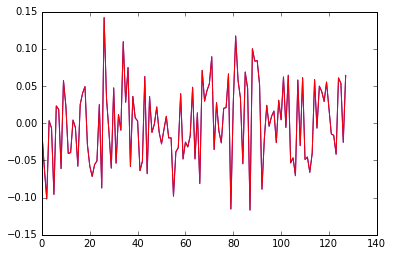

In [72]:
plt.plot(testCont(sessionsMinibatch)[0][2][-1].squeeze(), 'b', testCont(sessionsMinibatch)[0][3][-1].squeeze(), 'r')
plt.show()

In [59]:
np.where((sessionsMinibatch[1][-1] == sessionsMinibatch[2][-1]) == False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 array([  0,  26, 140,  21, 249, 128,  64,  97, 134, 154, 241, 245,   8,
          0,  69,   0,   0,  40,  46, 178,  64,   0, 128,   6, 247, 233,
        192, 168,   3, 131,  65,  55, 206, 209, 218, 145,   0,  80, 175,
         70, 163, 161,  49,  96, 168,  34,  80,  16, 250, 240, 217,  98,
          0,   0, 256]))

In [73]:
for i in range(20):
    print np.mean(sessionsMinibatch[2][-1]==sessionsMinibatch[i][-1]), np.mean(testCont(sessionsMinibatch)[0][2][-1]==testCont(sessionsMinibatch)[0][i][-1])

0.996562905318 1.0
0.999286640726 1.0
1.0 1.0
0.999286640726 1.0
0.999286640726 1.0
0.999208819715 1.0
0.999286640726 1.0
0.999286640726 1.0
1.0 1.0
0.999208819715 1.0
0.999208819715 1.0
0.999208819715 1.0
0.996108949416 0.0
0.999286640726 1.0
0.996108949416 0.0
0.999208819715 1.0
0.999286640726 1.0
0.999208819715 1.0
0.999286640726 1.0
0.996108949416 0.0


In [44]:
cost = T.mean(scanOut)
#cost = BinaryCrossEntropy().apply(Y, softout)
cg = ComputationGraph([cost])
learning_rate = 0.0001
params = VariableFilter(roles = [PARAMETER])(cg.variables)
updates = Adam(params, cost, learning_rate, c=5) #c is gradient clipping parameter
#updates = RMSprop(cost, params, learning_rate, c=5)

gradients = T.grad(cost, params)
gradients = clip_norms(gradients, 1)
gradientFun = theano.function([X], gradients, allow_input_downcast=True)

In [45]:
print "compiling you beautiful person"
train = theano.function([X], cost, updates = updates, allow_input_downcast=True)
#predict = theano.function([X], softout, allow_input_downcast=True)
print "finished compiling"

compiling you beautiful person
finished compiling


In [47]:
#Eventually we will need to do all of the transformations on the fly so we can pull from disc
hexSessionsKeys = hexSessions.keys()
#random.shuffle(hexSessionsKeys)
trainPercent = 0.9
trainIndex = int(len(hexSessionsKeys)*trainPercent)

runname = 'hred'
epochCost = []
gradNorms = []

epochs = 10
batch_size = 20
iteration = 0


for epoch in xrange(epochs):
    costCollect = []

    for start, end in zip(range(0, trainIndex,batch_size), range(batch_size, trainIndex, batch_size)):
        #build a 4d array of oneHot sessions
        
        trainingSessions = []
        for trainKey in range(start, end):
            sessionForEncoding = hexSessions[hexSessions.keys()[trainKey]]
            oneHotSes = oneSessionEncoder(sessionForEncoding, packetReverse=packetReverse, 
                                          padOldTimeSteps = packetReverse,
                                          hexDict = hexDict,
                                          maxPackets = maxPackets, packetTimeSteps = packetTimeSteps)
            trainingSessions.append(oneHotSes)
            
        sessionsMinibatch = np.asarray(trainingSessions)
        
    
        costfun = train(sessionsMinibatch)
        costCollect.append(costfun)
                
        iteration+=1
        
    ####SAVE COST TO FILE  
    if epoch%2 == 0:
        print(' ')
        print 'Epoch: ', epoch
        epochCost.append(np.mean(costCollect))
        print 'Epoch cost average: ', epochCost[-1]
        #grads = gradientFun(inputs, outputs)
        #for gra in grads:
        #    print '  gradient norms: ', np.linalg.norm(gra)
        
    np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")

 
Epoch:  0
Epoch cost average:  710.844
 
Epoch:  2
Epoch cost average:  707.899
 
Epoch:  4
Epoch cost average:  705.632
 
Epoch:  6
Epoch cost average:  703.782
 
Epoch:  8
Epoch cost average:  702.137


# Classifier

In [48]:
Y = T.matrix('targets')
batch_sizeClass = 20
numClasses = 2
clippings = 5
learning_rateClass = 0.001
classifierWts = IsotropicGaussian(0.08, 0)

bmlp = BatchNormalizedMLP(activations=[Tanh(),Tanh()], 
           dims=[dimDec, dimDec, 2],
           weights_init=classifierWts,
           biases_init=Constant(0.0) )


bmlp.initialize()

def oneStep(X):
    ###ENCODER
    
    data1class, data2class = fork.apply(X) #reusing the weights from fork, rnn, and rnnContext
    
    if rnnType == 'gru':
        hEncclass = rnn.apply(data1class, data2class)[:,-1] #the [:,-1] gets the last hidden state for 
                                                            #each obs in minibatch i.e. the last state 
                                                            #for each sentence
    else:
        hinitclass, _ = rnn.apply(data2class)
        hEncclass = hinitclass[:,-1]
    
    hEncclass = T.reshape(hEncclass,(maxPackets, 1, dim))
    
    data3class, data4class = forkContext.apply(hEncclass)
    
    if rnnType == 'gru':
        hContextClass = rnnContext.apply(data3class, data4class)
    else:
        hinitContextClass, _ = rnnContext.apply(data4class)
        hContextClass = hinitContextClass
    
    if bidirectional:
        
        data3classRev = data3class[::-1]
        data4classRev = data4class[::-1]
        
        if rnnType == 'gru':
            hContextRev = rnnContextRev.apply(data3classRev, data4classRev)
        else:
            hinitContextRevClass, _ = rnnContextRev.apply(data4classRev)
            hContextRevClass = hinitContextRevClass
        
        hContextClass = T.concatenate((hContextClass, hContextRevClass), axis=2)
        
    return hContextClass

In [49]:
hContextClass, _ = theano.scan(fn = oneStep, sequences=[X])

In [50]:
#newhContextClass = hContextClass[:, -1].reshape((batch_sizeClass, dimDec)) 
newhContextClass = T.mean(hContextClass, axis = (1,2))
pyx = bmlp.apply(newhContextClass)
softmax = Softmax()
softoutClass = softmax.apply(pyx)
costClass = T.mean(BinaryCrossEntropy().apply(Y, softoutClass))

In [51]:
cgClass = ComputationGraph([costClass])
paramsClass = VariableFilter(roles = [PARAMETER])(cgClass.variables)

In [52]:
updatesClass = Adam(paramsClass, costClass, learning_rateClass, c=clippings) 
#updatesClass = RMSprop(costClass, paramsClass, learning_rateClass, c=clippings)

print 'grad compiling'
gradients = T.grad(costClass, paramsClass)
gradients = clip_norms(gradients, clippings)
gradientFun = theano.function([X,Y], gradients, allow_input_downcast=True)
print 'finish with grads'

In [53]:
print 'compiling functions you talented soul'
classifierTrain = theano.function([X,Y], [softoutClass,costClass], updates=updatesClass, allow_input_downcast=True)
#classifierPredict = theano.function([X], softoutClass, allow_input_downcast=True)
print 'finished compiling'

compiling functions you talented soul
finished compiling


In [54]:
runname = 'hredClassify'
epochCost = []
gradNorms = []

epochs = 300
iteration = 0

normalTarget = np.array([0,1], dtype=theano.config.floatX)
abbyTarget = np.array([1,0], dtype=theano.config.floatX)

for epoch in xrange(epochs):
    costCollect = []

    for start, end in zip(range(0, trainIndex,batch_sizeClass/2),
                          range(batch_sizeClass/2, trainIndex, batch_sizeClass/2)):

        #build a 4d array of oneHot sessions
        
        trainingTargets = []
        trainingSessions = []
        for trainKey in range(start, end):
            sessionForEncoding = hexSessions[hexSessions.keys()[trainKey]]
            
            #encode a normal session
            oneHotSes = oneSessionEncoder(sessionForEncoding,hexDict = hexDict, packetReverse=packetReverse, 
                                          padOldTimeSteps = packetReverse, maxPackets = maxPackets,
                                          packetTimeSteps = packetTimeSteps)
            trainingSessions.append(oneHotSes)
            trainingTargets.append(normalTarget)
            
            #encode an abby normal session
            abbyHexSession = oneIpDirSwitcher(sessionForEncoding)
            abbyOneHotSes = oneSessionEncoder(abbyHexSession,hexDict = hexDict,packetReverse=packetReverse, 
                                          padOldTimeSteps = packetReverse, maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)
            trainingSessions.append(abbyOneHotSes)
            trainingTargets.append(abbyTarget)
             
        sessionsMinibatch = np.asarray(trainingSessions, dtype=theano.config.floatX)
        targetsMinibatch = np.asarray(trainingTargets, dtype=theano.config.floatX)
    
        costfun = classifierTrain(sessionsMinibatch, targetsMinibatch)
        costCollect.append(costfun[1])
                
        iteration+=1
        
    ####SAVE COST TO FILE  
    if epoch%2 == 0:
        print(' ')
        print 'Epoch: ', epoch
        epochCost.append(np.mean(costCollect))
        print 'Epoch cost average: ', epochCost[-1]
        #grads = gradientFun(sessionsMinibatch, targetsMinibatch)
        print 'pyx: ', costfun[0]
        #for gra in grads:
        #    print '  gradient norms: ', np.linalg.norm(gra)
        
    np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")

KeyboardInterrupt: 

# Advesarial Examples

In [ ]:
#create a dictionary of packet/session stats

#switch ips
#switch ports
#swap out and replace one ip

# Tests to show effectiveness

In [ ]:
#jack up ip field and see diff in prediction before and after
#jack up checksum and see diff in prediciton before and after

# Encoder RNN

In [ ]:
dim = 257 #original data dimension/timesteps/columns
rnnType = 'gru' #gru or lstm
bidirectional = True
X = T.tensor3('inputs')
Xrev = T.matrix('reversed_inputs')
linewt_init = Uniform(width=0.08)
rnnwt_init = IsotropicGaussian(0.05)
rnnbias_init = Constant(0.0)

if rnnType == 'gru':
    rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
    dimMultiplier = 2
else:
    rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
    dimMultiplier = 4

###RECURRENT LAYER

#To use or not to use that is the question
fork = Fork(output_names=['linear', 'gates'],
            name='fork', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = rnnbias_init)
data1, data2 = fork.apply(X)

###for raw inputs
#data1 = X
#data2 = T.concatenate([X]*dimMultiplier, axis=2)

if rnnType == 'gru':
    hEnc = rnn.apply(data1, data2)[:,-1] #the [:,-1] gets the last hidden state for each obs in minibatch
                                         #i.e. the last state for each sentence
else:
    hinit, _ = rnn.apply(data2)
    hEnc = hinit[:,-1]

hEnc = T.reshape(hEnc,(maxPackets, 1, dim))
#get weights initialized. without weights are nans.
fork.initialize()
rnn.initialize()

In [ ]:
#TEST Encoder will return a maxPackets x packet length matrix
encoder = theano.function([X], hEnc, allow_input_downcast=True)

In [ ]:
#TEST ENCODED PACKETS shape = (maxPackets, 1, dim)
encoder(sessions[1])

# Context RNN

X = T.tensor4('testInputs')
Y = T.vector('targets')
dim = 257 #original data dimension/timesteps/columns
dimDec = dim*2
rnnType = 'gru' #gru or lstm
bidirectional = True
linewt_init = Uniform(width=0.05)
rnnwt_init = IsotropicGaussian(0.02)
rnnbias_init = Constant(0.0)

def oneStep(X):
    ###ENCODER
    if rnnType == 'gru':
        rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
        dimMultiplier = 2
    else:
        rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
        dimMultiplier = 4
    
    #To use (fork) or not to use that is the question
    fork = Fork(output_names=['linear', 'gates'],
                name='fork', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
                weights_init = linewt_init, biases_init = rnnbias_init)
    data1, data2 = fork.apply(X)

    ###for raw inputs... for not using fork
    #data1 = X
    #data2 = T.concatenate([X]*dimMultiplier, axis=2)

    if rnnType == 'gru':
        hEnc = rnn.apply(data1, data2)[:,-1] #the [:,-1] gets the last hidden state for each obs in minibatch
                                             #i.e. the last state for each sentence
    else:
        hinit, _ = rnn.apply(data2)
        hEnc = hinit[:,-1]

    hEnc = T.reshape(hEnc,(maxPackets, 1, dim))

    fork.initialize()
    rnn.initialize()

    
    ###CONTEXT
    if rnnType == 'gru':
        rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                    biases_init = rnnbias_init, name = 'gruContext')
        dimMultiplier = 2
    else:
        rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                          name = 'lstmContext')
        dimMultiplier = 4

    ###RECURRENT LAYER
    forkContext = Fork(output_names=['linearContext', 'gatesContext'],
                name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
                weights_init = linewt_init, biases_init = rnnbias_init)
    data3, data4 = forkContext.apply(hEnc)

    if rnnType == 'gru':
        hContext = rnnContext.apply(data3, data4)
    else:
        hinitContext, _ = rnnContext.apply(data4)
        hContext = hinitContext

    #THINK ABOUT ADDING L2 POOLING BEFORE CAT
    if bidirectional:

        data3 = data3[::-1]
        data4 = data4[::-1]

        if rnnType == 'gru':
            rnnContextRev = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                           biases_init = rnnbias_init, name = 'gruContextRev')
            hContextRev = rnnContextRev.apply(data3, data4)
        else:
            rnnContextRev = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init,
                                 name = 'lstmContextRev')
            hinitContext, _ = rnnContextRev.apply(data4)
            hContextRev = hinitContext


        hContext = T.concatenate((hContext, hContextRev), axis=2)
        rnnContextRev.initialize()

    forkContext.initialize()
    rnnContext.initialize()

    
    ###DECODER
    
    if rnnType == 'gru':
        rnnDec = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruDecoder')
        dimMultiplier = 2
    else:
        rnnDec = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')
        dimMultiplier = 4


    forkDec = Fork(output_names=['linear', 'gates'],
                name='forkDec', input_dim=dimDec, output_dims=[dim, dim*dimMultiplier], 
                weights_init = linewt_init, biases_init = rnnbias_init)

    forkFinal = Fork(output_names=['linear', 'gates'],
                name='forkDec', input_dim=dim, output_dims=[dim, dim*dimMultiplier], 
                weights_init = linewt_init, biases_init = rnnbias_init)

    data5, data6 = forkDec.apply(hContext)#reduce dimension of bidirectLSTM

    #decoding data needs to be one timestep (next packet in session) ahead, thus data1 we ignore the first packet
    #and the last hidden state of the context RNN.
    data7 = T.concatenate((data5[:-1,:,:], data1[1:, :-1, :]), axis=1) #data1 is the original embedding of X

    #data8 = T.concatenate((data7, data5), axis = 2)
    data8, data9 = forkFinal.apply(data7)


    if rnnType == 'gru':
        hDec = rnnDec.apply(data8, data9) 
    else:
        hinit, _ = rnnDec.apply(data9)
        hDec = hinit

    #Smooth out the probabilities of hDec
    softmax = NDimensionalSoftmax()
    softout = softmax.apply(hDec, extra_ndim = 1)


    precost = X[1:, :, :]*np.log(softout) + (1-X[1:, :, :])*np.log(1-softout)
    precost2 = -T.sum(T.sum(precost, axis = 2), axis = 1)
    #precost2 = -T.mean(T.sum(T.sum(precost, axis = 2), axis = 1))
    
    #cost = BinaryCrossEntropy().apply(X[1:, :, :], softout)

    forkDec.initialize()
    forkFinal.initialize()
    rnnDec.initialize()
    
    return precost2, hEnc, hContext, hDec, softout

In [ ]:

if rnnType == 'gru':
    rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruContext')
    dimMultiplier = 2
else:
    rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                      name = 'lstmContext')
    dimMultiplier = 4


###ICLR suggestion -> don't use bias in RNNs

###RECURRENT LAYER
forkContext = Fork(output_names=['linearContext', 'gatesContext'],
            name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = rnnbias_init)
data3, data4 = forkContext.apply(hEnc)

if rnnType == 'gru':
    hContext = rnnContext.apply(data3, data4)
else:
    hinitContext, _ = rnnContext.apply(data4)
    hContext = hinitContext

#THINK ABOUT ADDING L2 POOLING BEFORE CAT
if bidirectional:
    
    data3 = data3[::-1]
    data4 = data4[::-1]
    
    if rnnType == 'gru':
        rnnContextRev = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                       biases_init = rnnbias_init, name = 'gruContextRev')
        hContextRev = rnnContextRev.apply(data3, data4)
    else:
        rnnContextRev = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init,
                             name = 'lstmContextRev')
        hinitContext, _ = rnnContextRev.apply(data4)
        hContextRev = hinitContext
    
    
    hContext = T.concatenate((hContext, hContextRev), axis=2)
    rnnContextRev.initialize()
    
#get weights initialized. without weights are nans.
forkContext.initialize()
rnnContext.initialize()

In [ ]:
#TEST output shape = (maxPackets, 1, dim*2)
context = theano.function([X], hContext, allow_input_downcast=True)

In [ ]:
#TEST
context(sessions[1]).shape

# Decoder RNN

In [ ]:
dimDec = dim*2

if rnnType == 'gru':
    rnnDec = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                            biases_init = rnnbias_init, name = 'gruDecoder')
    dimMultiplier = 2
else:
    rnnDec = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')
    dimMultiplier = 4


forkDec = Fork(output_names=['linear', 'gates'],
            name='forkDec', input_dim=dimDec, output_dims=[dim, dim*dimMultiplier], 
            weights_init = linewt_init, biases_init = rnnbias_init)

forkFinal = Fork(output_names=['linear', 'gates'],
            name='forkDec', input_dim=dim, output_dims=[dim, dim*dimMultiplier], 
            weights_init = linewt_init, biases_init = rnnbias_init)

data5, data6 = forkDec.apply(hContext)#reduce dimension of bidirectLSTM

#decoding data needs to be one timestep (next packet in session) ahead, thus data1 we ignore the first packet
#and the last hidden state of the context RNN.
data7 = T.concatenate((data5[:-1,:,:], data1[1:, :-1, :]), axis=1) #data1 is the original embedding of X

#data8 = T.concatenate((data7, data5), axis = 2)
data8, data9 = forkFinal.apply(data7)


if rnnType == 'gru':
    hDec = rnnDec.apply(data8, data9) 
else:
    hinit, _ = rnnDec.apply(data9)
    hDec = hinit

#Smooth out the probabilities of hDec
softmax = NDimensionalSoftmax()
softout = softmax.apply(hDec, extra_ndim = 1)
    

precost = X[1:, :, :]*np.log(softout) + (1-X[1:, :, :])*np.log(1-softout)
cost = -T.mean(T.sum(T.sum(precost, axis = 2), axis = 1))
#cost = BinaryCrossEntropy().apply(X[1:, :, :], softout)

#get weights initialized
forkDec.initialize()
forkFinal.initialize()
rnnDec.initialize()

In [8]:
   
'''def oneHotSessions(sessionDict, hexDict = hexDict, maxPackets = maxPackets, packetTimeSteps = packetTimeSteps,
                   reverse = False, charLevel = False):
    """
    This takes a list of int tokens and onehot encodes them, pads sessions with zero tensors according to maxPackets
    and packet according to packetTimeSteps
    
    sessionDict = dict of lists of key = sessions and value = list of packets
    timeSteps = maximum len of packet. it will be padded with zero vectors is packet is too short.
    
    """
    
    listOsessions = []

    if charLevel:
        vecLen = 17
    else:
        vecLen = 257
    
    sessionKeys = sessionDict.keys()
    
    for session in sessionKeys:
        
        sessionCollect = oneSessionEncoder(session, hexDict = hexDict, maxPackets = maxPackets, 
                                           packetTimeSteps = packetTimeSteps, reverse = reverse, 
                                           charLevel = charLevel )
        
        listOsessions.append(sessionCollect)
        
    return listOsessions'''

'def oneHotSessions(sessionDict, hexDict = hexDict, maxPackets = maxPackets, packetTimeSteps = packetTimeSteps,\n                   reverse = False, charLevel = False):\n    """\n    This takes a list of int tokens and onehot encodes them, pads sessions with zero tensors according to maxPackets\n    and packet according to packetTimeSteps\n    \n    sessionDict = dict of lists of key = sessions and value = list of packets\n    timeSteps = maximum len of packet. it will be padded with zero vectors is packet is too short.\n    \n    """\n    \n    listOsessions = []\n\n    if charLevel:\n        vecLen = 17\n    else:\n        vecLen = 257\n    \n    sessionKeys = sessionDict.keys()\n    \n    for session in sessionKeys:\n        \n        sessionCollect = oneSessionEncoder(session, hexDict = hexDict, maxPackets = maxPackets, \n                                           packetTimeSteps = packetTimeSteps, reverse = reverse, \n                                           charLevel = charLeve

In [ ]:
#TEST
decoder = theano.function([X], cost, allow_input_downcast=True)

In [ ]:
#X = T.tensor4('input')
decoderTest = theano.function([X], cost, allow_input_downcast=True)

In [ ]:
#TODO: make a training function
runname = 'firstRun'
epochCost = []
gradNorms = []

epochs = 200000
batch_size = 64
iteration = 0

for epoch in xrange(epochs):
    
    costCollect = []

    for start, end in zip(range(0, len(trainData),batch_size), range(batch_size, len(trainData), batch_size)):
        
        inputs = trainData[start:end]
        outputs = targetMaker(inputs)
        costfun = train(inputs, outputs)
        
        
        costCollect.append(costfun)
                
        iteration+=1
        
    ####SAVE COST TO FILE  
    if epoch%30 == 0:
        print(' ')
        print 'Epoch: ', epoch
        epochCost.append(np.mean(costCollect))
        print 'Epoch cost average: ', epochCost[-1]
        grads = gradientFun(inputs, outputs)
        for gra in grads:
            print '  gradient norms: ', np.linalg.norm(gra)
        
    
    np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")


# Converting to CPU

In [ ]:
#GPU TO CPU conversion
#Now get the weights from the test function. These weights will be numpy arrays
w1 = test.get_shared()[0].get_value()

#Here the weights are going to be set to the numpy arrays taken from the GPU predict function
input_linear.parameters[0].set_value(w1)

In [ ]:
test.get_shared()[2].get_value().shape

In [ ]:
chars = '1234567890abcdefghijklmnopqrstuvwxyz'
words = ['']

# Scratchpad

#we add 256 on the end to signify the end of the packet ('EOP')

maxPackets = 10 #limit the number of packets
tokSessions = []
oneHotSessions = []

for ses in hexSessions.keys():    
    tokPacket = []
    oneHotPacket = []
    for p in hexSessions[ses][:maxPackets]:
        tokP = [hexDict[p[i:i+2]] for i in xrange(0,len(p)-2+1,2)]+[256] #takes hexstring and tokenizes hex pairs
        tokPacket.append(tokP)
        oneHotPacket.append(oneHot(tokP))

    tokSessions.append(tokPacket)
    oneHotSessions.append(oneHotPacket)


###ALT RNN LAYER
def initialize(to_init):
    for bricks in to_init:
        bricks.weights_init = initialization.Uniform(width=0.08)
        bricks.biases_init = initialization.Constant(0)
        bricks.initialize()

def gru_layer(dim, h, n):
    fork = Fork(output_names=['linear' + str(n), 'gates' + str(n)],
                name='fork' + str(n), input_dim=dim, output_dims=[dim, dim * 2])
    gru = GatedRecurrent(dim=dim, name='gru' + str(n))
    initialize([fork, gru])
    linear, gates = fork.apply(h)
    return gru.apply(linear, gates)


def lstm_layer(dim, h, n):
    linear = Linear(input_dim=dim, output_dim=dim * 4, name='linear' + str(n))
    lstm = LSTM(dim=dim, name='lstm' + str(n))
    initialize([linear, lstm])
    return lstm.apply(linear.apply(h))
